# Algorithm

```Python
def extract_data():
    1. Read image
    2. Get Face ROI
    3. Get ROI for eyes and mouth
    4. Get landmark coordinates (eyes and mouth)
    5. Calculate EAR (Eye Aspect Ratio) & MAR (Mouth Aspect Ratio)

def generate_data():
    1. Loop through folder
    2. Extract data and store as one row with specified time frame (2 seconds or 60 frames)

def train():
    1. Split data
    2. Create LSTM model
    3. Train and validate
    4. Test model

def create_report():
    1. Calculate accuracy, precision, recall, and F1 score for train, validation, and test sets
    2. Support with visualizations


In [133]:

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

import mediapipe as mp
import tensorflow as tf

In [ ]:
# # MEDIAPIPE FACEMESH LANDMARK GUIDELINES

# // Lips.
# 61, 146, 146, 91, 91, 181, 181, 84, 84, 17, 17, 314, 314, 405, 405, 321,
# 321, 375, 375, 291, 61, 185, 185, 40, 40, 39, 39, 37, 37, 0, 0, 267, 267,
# 269, 269, 270, 270, 409, 409, 291, 78, 95, 95, 88, 88, 178, 178, 87, 87, 14,
# 14, 317, 317, 402, 402, 318, 318, 324, 324, 308, 78, 191, 191, 80, 80, 81,
# 81, 82, 82, 13, 13, 312, 312, 311, 311, 310, 310, 415, 415, 308,
# // Left eye.
# 33, 7, 7, 163, 163, 144, 144, 145, 145, 153, 153, 154, 154, 155, 155, 133,
# 33, 246, 246, 161, 161, 160, 160, 159, 159, 158, 158, 157, 157, 173, 173,
# 133,
# // Left eyebrow.
# 46, 53, 53, 52, 52, 65, 65, 55, 70, 63, 63, 105, 105, 66, 66, 107,
# // Left iris.
# 474, 475, 475, 476, 476, 477, 477, 474,
# // Right eye.
# 263, 249, 249, 390, 390, 373, 373, 374, 374, 380, 380, 381, 381, 382, 382,
# 362, 263, 466, 466, 388, 388, 387, 387, 386, 386, 385, 385, 384, 384, 398,
# 398, 362,
# // Right eyebrow.
# 276, 283, 283, 282, 282, 295, 295, 285, 300, 293, 293, 334, 334, 296, 296,
# 336,
# // Right iris.
# 469, 470, 470, 471, 471, 472, 472, 469,
# // Face oval.
# 10, 338, 338, 297, 297, 332, 332, 284, 284, 251, 251, 389, 389, 356, 356,
# 454, 454, 323, 323, 361, 361, 288, 288, 397, 397, 365, 365, 379, 379, 378,
# 378, 400, 400, 377, 377, 152, 152, 148, 148, 176, 176, 149, 149, 150, 150,
# 136, 136, 172, 172, 58, 58, 132, 132, 93, 93, 234, 234, 127, 127, 162, 162,
# 21, 21, 54, 54, 103, 103, 67, 67, 109, 109, 10};

In [87]:
# Inisialisasi Face Detection dari MediaPipe
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

IMG_SIZE = (116, 116)

# A. Extract Data

## 1. Read Image

- Resize to 116x116

In [112]:
# def read_images_from_folder(folder_path, img_size=IMG_SIZE):
#     """
#     Fungsi untuk membaca semua gambar dari folder tertentu dan mengembalikannya sebagai array.
#     Args:
#     - folder_path (str): Path folder berisi gambar.
#     - img_size (tuple): Ukuran gambar yang diinginkan (width, height).
    
#     Returns:
#     - images (list of tensors): Daftar tensor gambar yang sudah diubah ukurannya.
#     """
#     image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
#     images = []
    
#     for img_path in image_paths:
#         img = tf.io.read_file(img_path)
#         img = tf.image.decode_image(img, channels=3)
#         img = tf.image.resize(img, img_size)
#         images.append(img.numpy())  # Mengonversi tensor ke numpy array untuk penggunaan lebih lanjut
    
#     return images

# def display_images(images, num_images=5):
#     """
#     Fungsi untuk menampilkan beberapa gambar dari array menggunakan matplotlib.
#     Args:
#     - images (list of arrays): Daftar gambar dalam bentuk array.
#     - num_images (int): Jumlah gambar yang ingin ditampilkan.
#     """
#     plt.figure(figsize=(15, 15))
#     for i in range(min(num_images, len(images))):
#         plt.subplot(1, num_images, i + 1)
#         plt.imshow(images[i].astype("uint8"))
#         plt.axis("off")
#     plt.show()
    
def read_image(image_path, img_size=IMG_SIZE, resize=False):
    """
    Fungsi untuk membaca satu gambar menggunakan OpenCV dan mengembalikannya sebagai array.
    Args:
    - image_path (str): Path gambar.
    - img_size (tuple): Ukuran gambar yang diinginkan (width, height).
    
    Returns:
    - image (numpy array): Gambar yang sudah diubah ukurannya sebagai array.
    """
    img = cv2.imread(image_path)             # Membaca gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Mengubah format dari BGR (default OpenCV) ke RGB
    if resize == True:
        img = cv2.resize(img, img_size)          # Mengubah ukuran gambar sesuai img_size
    print(img.shape)
    return img  # Mengembalikan sebagai array numpy

def display_image(image, title=None, landmarks=None, display=None):
    """
    Fungsi untuk menampilkan satu gambar menggunakan matplotlib dengan opsi menambahkan judul dan landmark.
    Args:
    - image (numpy array): Gambar dalam bentuk array.
    - title (str, optional): Judul yang akan ditampilkan di atas gambar.
    - landmarks (list of tuples, optional): Daftar koordinat landmark yang akan ditampilkan pada gambar.
    """
    plt.imshow(image.astype("uint8"))
    if landmarks:
        for i, (x, y) in enumerate(landmarks):
            plt.plot(x, y, 'ro')  # Tampilkan landmark sebagai titik merah
            if display:
                plt.text(x, y, f'p{i+1}', color="yellow", fontsize=8, ha="center")  # Tambahkan label
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

    
# folder_path = "../../Datasets/NTHU-DDD/drowsy/001_glasses_sleepyCombination_599_drowsy.jpg"
# images = read_images_from_folder(folder_path)
# display_images(images, num_images=5)

(480, 640, 3)


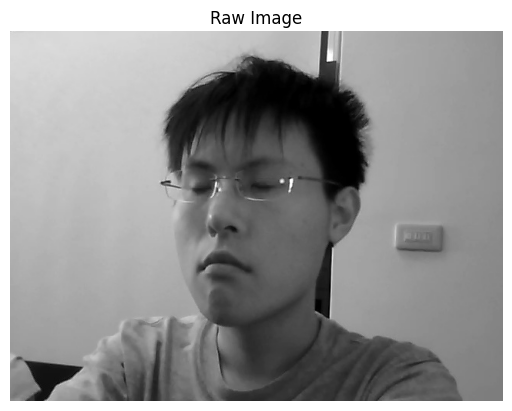

(116, 116, 3)


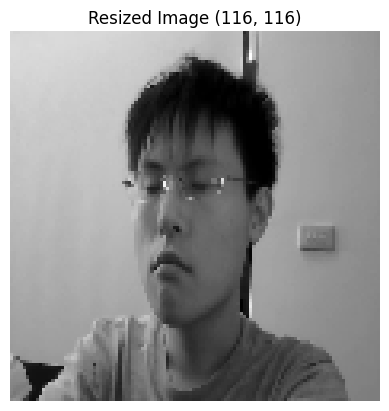

In [102]:
raw = dict()
rsz = dict()

file_path = "../../Datasets/NTHU-DDD/drowsy/006_glasses_slowBlinkWithNodding_499_drowsy.jpg"
raw['img'] = read_image(file_path, resize=False)
display_image(raw['img'], "Raw Image")

rsz['img'] = read_image(file_path, resize=True)
display_image(rsz['img'], f"Resized Image {IMG_SIZE}")

## 2. Get Face ROI

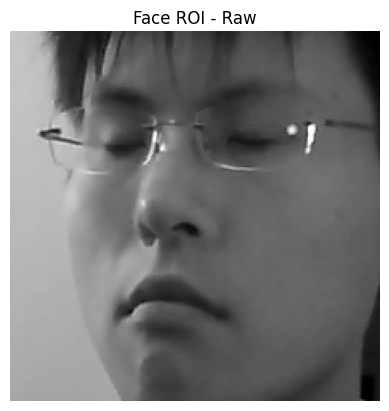

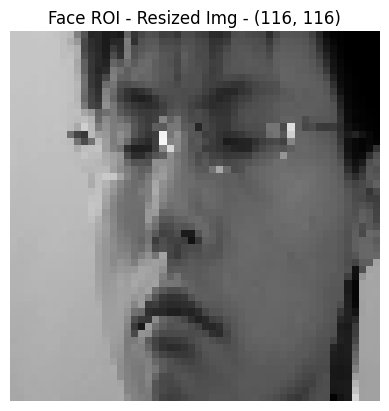

In [106]:
def get_face_roi_mediapipe(image):
    """
    Fungsi untuk mendeteksi satu wajah dan mengembalikan ROI wajah dari gambar menggunakan MediaPipe.
    Args:
    - image (numpy array): Gambar dalam bentuk array.
    
    Returns:
    - face_roi (array): ROI wajah yang terdeteksi, atau None jika tidak ada wajah terdeteksi.
    """
    face_roi = None
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Konversi gambar ke RGB karena MediaPipe menggunakan RGB
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.detections:
            # Ambil bounding box dari wajah pertama yang terdeteksi
            detection = results.detections[0]
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
            
            # Ekstrak ROI wajah berdasarkan bounding box
            face_roi = image[y:y+h, x:x+w]
                
    return face_roi


raw['face_roi'] = get_face_roi_mediapipe(raw['img'])  # Menggunakan variabel `img` yang sudah ada
display_image(raw['face_roi'], "Face ROI - Raw")

rsz['face_roi'] = get_face_roi_mediapipe(rsz['img'])  # Menggunakan variabel `img` yang sudah ada
display_image(rsz['face_roi'], f"Face ROI - Resized Img - {IMG_SIZE}")

## 3. Get Eyes and Mouth ROI

In [90]:
def get_eye_and_mouth_roi(image):
    """
    Fungsi untuk mendeteksi ROI mata (garis kepala) dan mulut menggunakan MediaPipe,
    dengan memastikan ROI memiliki orientasi landscape.
    Args:
    - image (numpy array): Gambar dalam bentuk array.
    
    Returns:
    - eye_roi (array): ROI untuk area mata atau None jika tidak terdeteksi.
    - mouth_roi (array): ROI untuk area mulut atau None jika tidak terdeteksi.
    - eye_roi_coords (tuple): Koordinat (x, y, width, height) untuk ROI mata.
    - mouth_roi_coords (tuple): Koordinat (x, y, width, height) untuk ROI mulut.
    """
    eye_roi, mouth_roi = None, None
    eye_roi_coords, mouth_roi_coords = None, None
    
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        # Konversi gambar ke RGB, karena MediaPipe menggunakan RGB
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks:
            # Ambil landmark wajah pertama yang terdeteksi
            face_landmarks = results.multi_face_landmarks[0]
            ih, iw, _ = image.shape
            
            # Landmark koordinat untuk mata (landmark 33 dan 263 untuk garis sekitar mata kiri dan kanan)
            left_eye_x = int(face_landmarks.landmark[33].x * iw)
            left_eye_y = int(face_landmarks.landmark[33].y * ih)
            right_eye_x = int(face_landmarks.landmark[263].x * iw)
            
            # Buat ROI mata sebagai area yang lebih lebar (landscape)
            eye_roi_width = abs(right_eye_x - left_eye_x) + 40  # Tambahkan toleransi lebar
            eye_roi_height = eye_roi_width // 2  # Pastikan lebar lebih besar dari tinggi (landscape)
            y_eye_top = max(0, left_eye_y - eye_roi_height // 2)
            x_eye_left = max(0, left_eye_x - 20)
            eye_roi = image[y_eye_top:y_eye_top + eye_roi_height, x_eye_left:x_eye_left + eye_roi_width]
            eye_roi_coords = (x_eye_left, y_eye_top, eye_roi_width, eye_roi_height)

            # Landmark koordinat untuk mulut (landmark 13 dan 14 untuk bagian atas dan bawah mulut)
            mouth_top_y = int(face_landmarks.landmark[13].y * ih)
            mouth_bottom_y = int(face_landmarks.landmark[14].y * ih)
            
            # Hitung tinggi kepala untuk orientasi landscape pada ROI mulut
            forehead_y = int(face_landmarks.landmark[10].y * ih)
            chin_y = int(face_landmarks.landmark[152].y * ih)
            head_height = abs(chin_y - forehead_y)
            
            # Pastikan ROI mulut memiliki aspek landscape dengan lebar lebih besar dari tinggi
            mouth_roi_height = min(max(int(head_height * 0.25), abs(mouth_bottom_y - mouth_top_y)), int(head_height * 0.5))
            mouth_roi_width = mouth_roi_height * 2  # Set lebar lebih besar dari tinggi
            y_mouth_top = max(0, mouth_top_y - mouth_roi_height // 2)
            x_mouth_left = max(0, int(face_landmarks.landmark[61].x * iw) - 10)
            mouth_roi = image[y_mouth_top:y_mouth_top + mouth_roi_height, x_mouth_left:x_mouth_left + mouth_roi_width]
            mouth_roi_coords = (x_mouth_left, y_mouth_top, mouth_roi_width, mouth_roi_height)
                
    return eye_roi, eye_roi_coords, mouth_roi, mouth_roi_coords

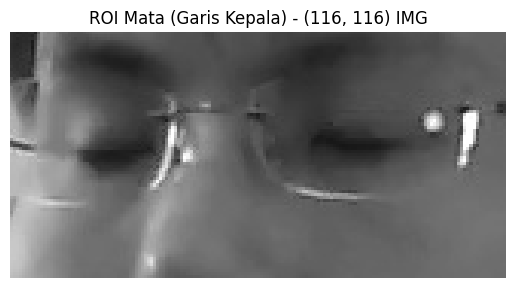

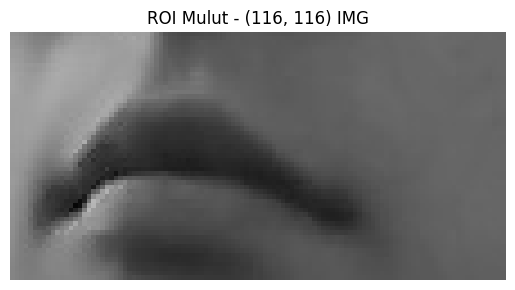

In [107]:
raw['eye_roi'], raw['eye_roi_coords'], raw['mouth_roi'], raw['mouth_roi_coords'] = get_eye_and_mouth_roi(raw['face_roi'])
  
display_image(raw['eye_roi'], title=f"ROI Mata (Garis Kepala) - {IMG_SIZE} IMG") if raw['eye_roi'] is not None else print("Mata tidak terdeteksi.")
display_image(raw['mouth_roi'], title=f"ROI Mulut - {IMG_SIZE} IMG") if raw['mouth_roi'] is not None else print("Mulut tidak terdeteksi.")

In [108]:
rsz['eye_roi'], rsz['eye_roi_coords'], rsz['mouth_roi'], rsz['mouth_roi_coords'] = get_eye_and_mouth_roi(rsz['face_roi'])
  
display_image(rsz['eye_roi'], title=f"ROI Mata (Garis Kepala) - {IMG_SIZE} IMG") if rsz['eye_roi'] is not None else print("Mata tidak terdeteksi.")
display_image(rsz['mouth_roi'], title=f"ROI Mulut - {IMG_SIZE} IMG") if rsz['mouth_roi'] is not None else print("Mulut tidak terdeteksi.")

Mata tidak terdeteksi.
Mulut tidak terdeteksi.


## 4. Get Landmark Coordinates (Eyes and Mouth)

In [129]:
def get_landmarks_for_aspect_ratio(image, eye_roi_coords, mouth_roi_coords):
    """
    Fungsi untuk mendapatkan koordinat 6 landmark untuk masing-masing mata (kiri dan kanan) dan 
    6 landmark mulut relatif terhadap ROI untuk perhitungan EAR dan MAR.
    Args:
    - image (numpy array): Gambar asli dalam bentuk array.
    - eye_roi_coords (tuple): Koordinat (x, y, width, height) dari ROI mata.
    - mouth_roi_coords (tuple): Koordinat (x, y, width, height) dari ROI mulut.
    
    Returns:
    - left_eye_landmarks (list): 6 koordinat landmark mata kiri relatif terhadap ROI mata kiri.
    - right_eye_landmarks (list): 6 koordinat landmark mata kanan relatif terhadap ROI mata kanan.
    - mouth_landmarks (list): 6 koordinat landmark mulut relatif terhadap ROI mulut.
    """
    left_eye_landmarks, right_eye_landmarks, mouth_landmarks = [], [], []

    # Landmark ID untuk mata kiri, mata kanan, dan mulut
    
    
    
    
    
    
    chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
    chosen_right_eye_idxs = [33, 160, 158, 133, 153, 144]
    chosen_mouth_idxs = [76, 38, 13, 268, 292, 316, 14, 86]

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        # Konversi gambar ke RGB, karena MediaPipe menggunakan RGB
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        if results.multi_face_landmarks:
            # Ambil landmark wajah pertama yang terdeteksi
            face_landmarks = results.multi_face_landmarks[0]
            ih, iw, _ = image.shape

            # Koordinat untuk ROI mata kiri
            x_left_eye, y_left_eye, left_eye_width, left_eye_height = eye_roi_coords
            left_eye_landmarks = [
                (int((face_landmarks.landmark[idx].x * iw) - x_left_eye), int((face_landmarks.landmark[idx].y * ih) - y_left_eye))
                for idx in chosen_left_eye_idxs
            ]

            # Koordinat untuk ROI mata kanan
            x_right_eye, y_right_eye, right_eye_width, right_eye_height = eye_roi_coords
            right_eye_landmarks = [
                (int((face_landmarks.landmark[idx].x * iw) - x_right_eye), int((face_landmarks.landmark[idx].y * ih) - y_right_eye))
                for idx in chosen_right_eye_idxs
            ]

            # Koordinat untuk ROI mulut
            x_mouth_left, y_mouth_top, mouth_roi_width, mouth_roi_height = mouth_roi_coords
            mouth_landmarks = [
                (int((face_landmarks.landmark[idx].x * iw) - x_mouth_left), int((face_landmarks.landmark[idx].y * ih) - y_mouth_top))
                for idx in chosen_mouth_idxs
            ]
                
    return left_eye_landmarks, right_eye_landmarks, mouth_landmarks

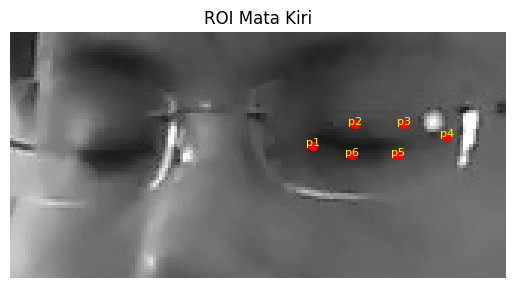

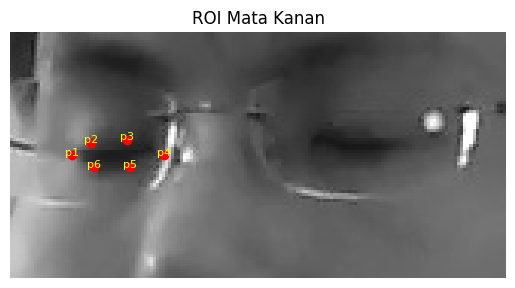

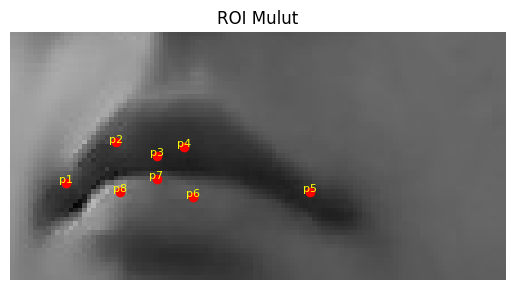

In [131]:
raw['left_eye_landmarks'], raw['right_eye_landmarks'], raw['mouth_landmarks'] = get_landmarks_for_aspect_ratio(raw['face_roi'], raw['eye_roi_coords'], raw['mouth_roi_coords'])

# Menampilkan ROI dan landmark masing-masing
display_image(raw['eye_roi'], title="ROI Mata Kiri", landmarks=raw['left_eye_landmarks'], display=True)
display_image(raw['eye_roi'], title="ROI Mata Kanan", landmarks=raw['right_eye_landmarks'], display=True)
display_image(raw['mouth_roi'], title="ROI Mulut", landmarks=raw['mouth_landmarks'], display=True)

## 5. Calculate MAR and EAR

In [135]:
def calculate_ear(left_eye_landmarks, right_eye_landmarks):
    """
    Menghitung Eye Aspect Ratio (EAR) berdasarkan landmark mata kiri dan mata kanan.
    
    Args:
    - left_eye_landmarks (list of tuples): Daftar koordinat (x, y) untuk mata kiri.
    - right_eye_landmarks (list of tuples): Daftar koordinat (x, y) untuk mata kanan.
    
    Returns:
    - ear_left (float): Nilai EAR untuk mata kiri.
    - ear_right (float): Nilai EAR untuk mata kanan.
    """
    def ear_single_eye(eye_landmarks):
        # Menghitung EAR untuk satu mata
        p1, p2, p3, p4, p5, p6 = eye_landmarks
        vertical_1 = np.linalg.norm(np.array(p2) - np.array(p5))
        vertical_2 = np.linalg.norm(np.array(p3) - np.array(p6))
        horizontal = np.linalg.norm(np.array(p1) - np.array(p4))
        ear = (vertical_1 + vertical_2) / (2.0 * horizontal)
        return ear

    # EAR untuk mata kiri dan mata kanan
    ear_left = ear_single_eye(left_eye_landmarks)
    ear_right = ear_single_eye(right_eye_landmarks)
    return ear_left, ear_right


def calculate_mar(mouth_landmarks):
    """
    Menghitung Mouth Aspect Ratio (MAR) berdasarkan landmark mulut.
    
    Args:
    - mouth_landmarks (list of tuples): Daftar koordinat (x, y) untuk mulut.
    
    Returns:
    - mar (float): Nilai MAR untuk mulut.
    """
    # Mengambil koordinat titik-titik yang sesuai dari landmark mulut
    p1, p2, p3, p4, p5, p6, p7, p8 = mouth_landmarks
    vertical_1 = np.linalg.norm(np.array(p2) - np.array(p8))
    vertical_2 = np.linalg.norm(np.array(p3) - np.array(p7))
    horizontal = np.linalg.norm(np.array(p1) - np.array(p5))
    mar = (vertical_1 + vertical_2) / (2.0 * horizontal)
    return mar


In [137]:
mar = calculate_mar(raw['mouth_landmarks'])
ear_left, ear_right = calculate_ear(raw['left_eye_landmarks'], raw['right_eye_landmarks'])

print(f"{mar}\n{ear_left}\t{ear_right}")

0.1484663636816505
0.4186613349788609	0.4912834654337607


# B. Generate Data

# C. Train

# D. Create Report